In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Mall_Customers.csv to Mall_Customers.csv


In [ ]:
#@title imports

import numpy as np
import pandas as pd
from pandas import plotting
import matplotlib.pyplot as plt
import seaborn as sns

import plotly as py

from sklearn.preprocessing import StandardScaler

import seaborn as sns
from plotly import tools
from plotly.subplots import make_subplots
import plotly.offline as py
from sklearn.preprocessing import LabelEncoder
%matplotlib inline

In [ ]:
#@title Preprocessing of data
dataset = pd.read_csv('Mall_Customers.csv')
dataset.rename(index=str, columns={'Annual Income (k$)': 'Income',
                              'Spending Score (1-100)': 'Score'}, inplace=True)
dataset.drop('CustomerID',axis=1,inplace=True)
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(dataset['Gender'].values)
dataset['Gender'] = integer_encoded
dataset.head(3)

,Gender,Age,Income,Score
0,1,19,15,39
1,1,21,15,81
2,0,20,16,6


In [ ]:
#@title T2FCM
class T2FCM:
    def __init__(self,
                 min_improvement,
                 n_clusters,
                 max_iterations,
                 fuzzification_degree,
                 dirichlet_concentration_params=None,
                 metric='euclidean',
                 verbose=False):
        self.objective = np.inf
        self.objective_history = []
        self.max_iterations = max_iterations
        self.min_improvement = min_improvement
        self.n_clusters = n_clusters
        self.fuzzification_degree = fuzzification_degree
        self.dirichlet_concentration_params = dirichlet_concentration_params
        self.metric = self.__get_metric(metric)
        self.verbose = verbose
        self._vpc = np.nan

    def get_random_dirichlet_membership(self,dirichlet_concentration_params):

        if dirichlet_concentration_params is None:
            dirichlet_concentration_params = np.array([2.0]*self.n_clusters)

        assert dirichlet_concentration_params.shape[0] == self.n_clusters, \
            f"dirichlet_concentration_params {dirichlet_concentration_params} does not match the number of clusters {n_clusters}"

        return np.random.dirichlet(dirichlet_concentration_params,size=self.n_samples)

    def set_membership_degree(self,membership_degree):
        self.membership_degree = membership_degree
    def set_type2_scores(self,type2_scores):
        self.type2_scores=type2_scores
    def fit(self,X,init_membership_degree=None,init_type2_scores=None):
        self.X = X
        self.n_samples, self.n_features = self.X.shape
        self.distance_matrix = np.zeros(shape=(self.n_samples,self.n_clusters))
        if init_membership_degree is None:
            init_membership_degree = self.get_random_dirichlet_membership(self.dirichlet_concentration_params)
        self.set_membership_degree(init_membership_degree)
        self.normalize_membership_degree()
        if init_type2_scores is None:
           self.type2_scores = self.membership_degree - (1-self.membership_degree)/2
        self.set_type2_scores(init_type2_scores)

        iteration = 0
        while True:
            self.update_centers2()
            self.update_distances()
            self.update_type2_scores()
            self.update_membership_degree()
            self.update_objective()
            if self.stopping_criterion(iteration):
                print(self.MCD(),self.xi_beni(),self.lables())
                break
            iteration += 1
            if self.verbose:
                print(self.MCD(),self.xi_beni(),self.lables())

    def update_centers(self):
        self.fuzzy_type2_scores = (self.membership_degree - (1-self.membership_degree)/2)** self.fuzzification_degree
        self.centers = (self.fuzzy_type2_scores.T @ self.X)/np.expand_dims(self.fuzzy_type2_scores.sum(axis=0),1)
    def update_objective(self):
        self.fuzzy_membership_degree = self.membership_degree ** self.fuzzification_degree
        self.objective = (self.fuzzy_membership_degree * self.distance_matrix_squared).sum()
        self.objective_history.append(self.objective)

    def stopping_criterion(self,iteration):
        if iteration > self.max_iterations:
            return True

        if iteration > 2:
            self.improvement = np.abs(self.objective_history[-2] - self.objective_history[-1])
            return self.improvement < self.min_improvement

        return False

    def update_distances(self):
        for center_idx in range(self.n_clusters):
            self.distance_matrix[:,center_idx] = self.metric(np.expand_dims(self.centers[center_idx],0),self.X)

    def update_membership_degree(self):
        self.distance_matrix_squared = self.distance_matrix ** 2
        for center_idx in range(self.n_clusters):
            for sample_idx in range(self.n_samples):
                temp = self.distance_matrix_squared[sample_idx,center_idx]/self.distance_matrix_squared[sample_idx,:]
                self.membership_degree[sample_idx,center_idx] = 1/((temp.sum())**(2/(self.fuzzification_degree-1)))
        self.normalize_membership_degree()

    def normalize_membership_degree(self):
        self.membership_degree = self.membership_degree/self.membership_degree.sum(axis=1,keepdims=True)

    def __get_metric(self,name):
        metrics = {'euclidean' : self.__euclid_metric,
                   'cosine': self.__cosine_metric}
        return metrics[name]

    def __euclid_metric(self,x,y):
        return np.linalg.norm(x-y,axis=1)

    def __cosine_metric(self,x,y):
        return 1 - np.dot(x,y.T)/(np.linalg.norm(x)*np.linalg.norm(y))

    def update_type2_scores(self):
        self.type2_scores = self.membership_degree - (1-self.membership_degree)/2
    def MCD(self):
        M=[]
        for i in (self.centers):
          for j in (self.centers):
            M.append((np.linalg.norm(i-j))**2)
            if 0 in M:
                M.remove(0)
        M.sort()
        self.F=M[0]
        return self.F
    def update_centers2(self):
        self.fuzzy_type2_scores = (self.membership_degree - (1-self.membership_degree)/2)** self.fuzzification_degree
        self.centers = (self.fuzzy_type2_scores.T @ self.X)/np.expand_dims(self.fuzzy_type2_scores.sum(axis=0),1)
        return self.centers
    def xi_beni(self):
         b=[]
         for i in (self.centers):
            for j in (self.centers):
                  b.append((np.linalg.norm(i-j))**2)
            if 0 in b:
                b.remove(0)
         b.sort()
         c=b[0]
         self.a=(self.n_samples)*c
         return self.a
    def lables(self):
        self.predict= np.argmax(self.membership_degree, axis=1)
        return self.predict

1215.9961920117187 243199.23840234373 [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 1 0 1 0 1 0 1 0 1
 0 1 0 1 0 1 0 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 0 1 1 1 1 1
 1 0 1 1 0 1 1 1 1 1 0 1 1 0 0 1 1 1 1 1 1 0 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1
 0 1 0 0 0 1 0 1 0 0 1 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0
 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1
 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0]
216.63370560817114 43326.74112163423 [0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0
 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0
 0 1 0 0 1 0 0 0 0 0 1 0 0 1 1 0 0 2 0 2 2 1 0 2 0 2 2 0 0 1 0 2 0 0 0 0 0
 1 2 2 2 2 0 1 2 1 1 2 1 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1
 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2
 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1]
0.23952795574154748 47.9055911483095 [3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 3

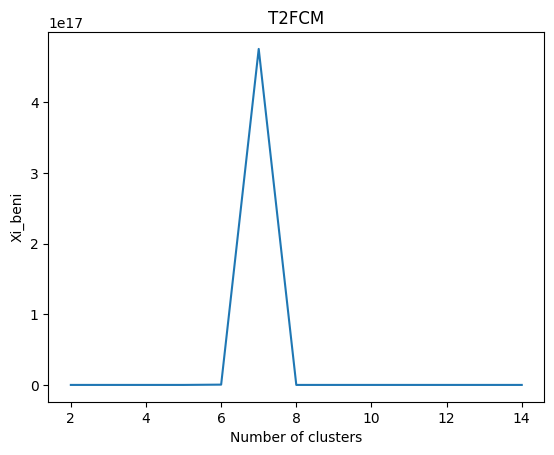

In [ ]:
#@title Determining optimal number of clusters using xi and beni index
cmin=2
n_samples=200
cmax=np.sqrt(n_samples)
cmax=int(cmax)
cmax+=1
hub=[]
clusters = range(cmin,cmax)
epsilon = 0.5
x=dataset
for i in clusters:
    n_centers=i
    clustering_instance = T2FCM(min_improvement=0.1,
                             n_clusters=n_centers,
                             max_iterations=100,
                             fuzzification_degree=2,
                             metric='euclidean')
    np_x = x.to_numpy()
    clustering_instance.fit(np_x)
    hub.append(clustering_instance.objective_history[-1]/(clustering_instance.a))
plt.title("T2FCM")
plt.xlabel('Number of clusters')
plt.ylabel('Xi_beni')
plt.plot(clusters,hub)

1212.318774980935 242463.754996187 [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 1 0 1 0 1 0 1 0 1
 0 1 0 1 0 1 0 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 0 1 1 1 1 1
 1 0 1 1 0 1 1 1 1 1 0 1 1 0 0 1 1 1 1 1 1 0 1 0 1 0 1 1 1 0 1 1 1 1 1 1 1
 0 1 0 0 0 1 0 1 0 0 1 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0
 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1
 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0]
214.05112880630992 42810.22576126199 [0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0
 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0
 0 1 0 0 1 0 0 0 0 0 1 0 0 1 1 0 0 2 0 2 2 1 0 2 0 2 2 0 0 1 0 2 0 0 0 0 0
 1 2 2 2 2 0 1 2 1 1 2 1 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1
 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2
 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1]
37.09245084982127 7418.490169964254 [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 

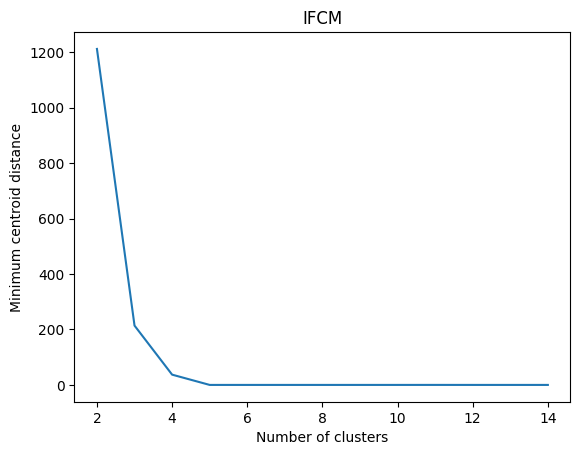

In [ ]:
#@ title Determining optimal number of clusters using Ⅿiniⅿuⅿ ⅽentroiⅾ ⅾistanⅽe index
cmin=2
n_samples=200
cmax=np.sqrt(n_samples)
cmax=int(cmax)
cmax+=1
hub=[]
clusters = range(cmin,cmax)
epsilon = 0.5
x=dataset
for i in clusters:
    n_centers=i
    clustering_instance = T2FCM(min_improvement=0.1,
                             n_clusters=n_centers,
                             max_iterations=100,
                             fuzzification_degree=2,
                             metric='euclidean')
    np_x = x.to_numpy()
    clustering_instance.fit(np_x)
    hub.append(clustering_instance.F)
plt.title("IFCM")
plt.xlabel('Number of clusters')
plt.ylabel('Ⅿiniⅿuⅿ ⅽentroiⅾ ⅾistanⅽe')
plt.plot(clusters,hub)

In [ ]:
#@title visualizations
n_centers = 2
epsilon = 0.5
x=dataset
clustering_instance = T2FCM(min_improvement=0.1,
                             n_clusters=n_centers,
                             max_iterations=100,
                             fuzzification_degree=2,
                             metric='euclidean')
np_x = x.to_numpy()
clustering_instance.fit(np_x)

1212.2620749312014 242452.41498624027 [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 1 0 1 0 1 0 1 0 1
 0 1 0 1 0 1 0 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 0 1 1 1 1 1
 1 0 1 1 0 1 1 1 1 1 0 1 1 0 0 1 1 1 1 1 1 0 1 0 1 0 1 1 1 0 1 1 1 1 1 1 1
 0 1 0 0 0 1 0 1 0 0 1 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0
 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1
 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0]


<Figure size 1200x800 with 0 Axes>

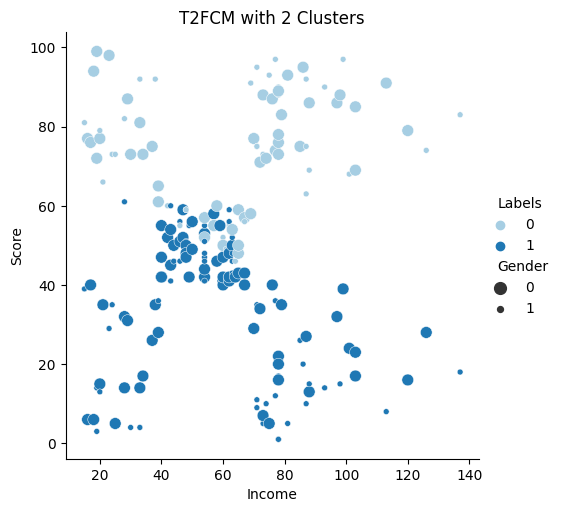

In [ ]:
x['Labels'] = clustering_instance.predict
clustering_centers = clustering_instance.centers
plt.figure(figsize=(12, 8))
sns.relplot(x='Income', y='Score', hue='Labels', size='Gender',
                 data=dataset,palette = "Paired")
plt.title('T2FCM with 2 Clusters')
plt.show()

In [ ]:
n_centers = 3
epsilon = 0.5
x=dataset
clustering_instance = T2FCM(min_improvement=0.1,
                             n_clusters=n_centers,
                             max_iterations=100,
                             fuzzification_degree=2,
                             metric='euclidean')
np_x = x.to_numpy()
clustering_instance.fit(np_x)

214.09672901705179 42819.34580341036 [0 0 0 0 0 0 0 2 0 0 0 2 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 2 0 0 0 2 0 2 0
 0 0 2 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 2 0 0 2 0 0 0 0 0
 0 2 0 0 2 0 0 0 0 0 2 0 0 2 2 0 0 1 0 1 1 2 0 1 0 1 1 0 0 2 0 1 0 0 0 0 0
 2 1 1 1 1 0 2 1 2 2 1 2 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2
 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1
 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2]


<Figure size 1200x800 with 0 Axes>

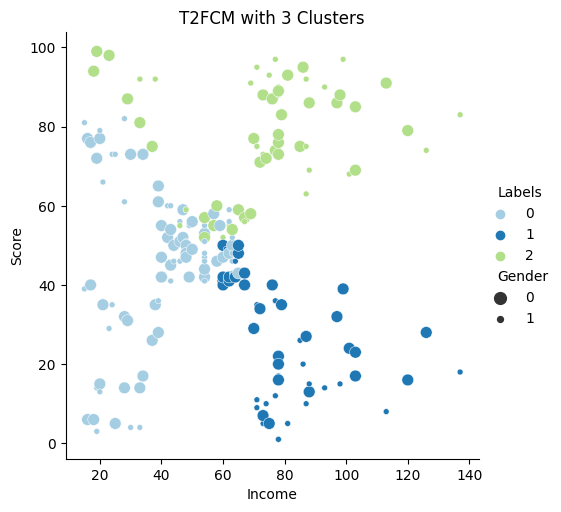

In [ ]:
x['Labels'] = clustering_instance.predict
clustering_centers = clustering_instance.centers
plt.figure(figsize=(12, 8))
sns.relplot(x='Income', y='Score', hue='Labels', size='Gender',
                 data=dataset,palette = "Paired")
plt.title('T2FCM with 3 Clusters')
plt.show()

In [ ]:
#@title Internal evaluation
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score


print("Silhouette score: {}".format(silhouette_score(dataset.drop(['Labels'],axis=1), clustering_instance.predict)))
print("Davies Bouldin score: {}".format(davies_bouldin_score(dataset.drop(['Labels'], axis=1),  clustering_instance.predict)))
print("Calinski Harabasz score: {}".format(calinski_harabasz_score(dataset.drop(['Labels'], axis=1), clustering_instance.predict)))

Silhouette score: 0.3107629859470868
Davies Bouldin score: 1.090255808984414
Calinski Harabasz score: 94.1621695853246


In [ ]:
#@title External evaluation
from sklearn.cluster import KMeans
km5 = KMeans(n_clusters=5).fit(x)
x['La'] = km5.labels_
x['Labels'] = clustering_instance.predict

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [ ]:
from sklearn.metrics import fowlkes_mallows_score
from sklearn.metrics import rand_score
from sklearn.metrics import v_measure_score
print("Rand score: {}".format(rand_score(km5.labels_, clustering_instance.predict)))
print("fowlkes mallows score: {}".format(fowlkes_mallows_score(km5.labels_, clustering_instance.predict)))
print("v measure score: {}".format(v_measure_score(km5.labels_, clustering_instance.predict)))

Rand score: 0.7196482412060301
fowlkes mallows score: 0.5370891657421663
v measure score: 0.4935588029988094
